# COVID19 Data Exploration with FugueSQL

This example will demonstrate how to use FugueSQL for exploratory data analysis. Normally, SparkSQL users find that SQL code is a second class citizen surrounded predominantly by Python code. FugueSQL can support a predominantly SQL code base that invokes Python code because Fugue SQL is treated as a first-class API in Fugue.

As we iterate through this problem, focus on how the problem is defined in a scale agnostic way. We'll show how to prototype on smaller pieces of data, before running on the larger dataset. 

This dataset is from [Kaggle Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset).

## Setup for Notebooks

Fugue has a `setup()` function for notebooks that registers the `%%fsql` cell [magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html). This lets us use FugueSQL cells in Jupyter notebooks with syntax highlighting (does not work for JupyterLab notebooks yet). The last part of the notebook will show how to move these cells into production using the `fsql` function.

The native Fugue `PRINT` can't print wide tables nicely in this environment, so we'll write an extension `pprint` to render the dataframes as pandas dataframes. Understanding the `pprint` function is not so important.

In [1]:
from fugue_notebook import setup
setup()

<IPython.core.display.Javascript object>

In [2]:
from fugue import NativeExecutionEngine, DataFrames, PandasDataFrame, Schema, Transformer, IterableDataFrame, ArrayDataFrame

def pprint(dfs:DataFrames, rows = 5, title=None):
    if title is not None:
        print(title)
    for df in dfs.values():
        pdf= PandasDataFrame(df.head(rows), df.schema)
        display(pdf.native)


## Imports

In [3]:
from fugue import NativeExecutionEngine, DataFrames, PandasDataFrame, Schema, Transformer, IterableDataFrame, ArrayDataFrame
from fugue_sql import FugueSQLWorkflow
from fugue_spark import SparkExecutionEngine
from IPython.display import display, HTML
from typing import Iterable, Dict, Any
from datetime import datetime
import pandas as pd

## Initial Exploration

First we'll explore how to use the `%%fsql` cell magic. We'll load two files and use `pprint` on them. The following will run on pandas-based `NativeExecutionEngine` because no engine is specified. There are a couple of FugueSQL features to note. First is how the `%%fsql` cell magic turned the cell into a FugueSQL cell. Second, FugueSQL allows variable assignments of the `confirmed` and `death` DataFrames. These are loaded in a pandas DataFrames because of the `NativeExecutionEngine`. Lastly, we used our `pprint` extension which was written in Python alongside out SQL code. 

In [4]:
%%fsql
confirmed = LOAD CSV "../../data/confirmed.csv"(header=true)
OUTPUT USING pprint(rows=5)
death = LOAD CSV "../../data/death.csv"(header=true)
OUTPUT USING pprint(rows=5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,_6_3_20,_6_4_20,_6_5_20,_6_6_20,_6_7_20,_6_8_20,_6_9_20,_6_10_20,_6_11_20,_6_12_20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,...,239,241,248,259,265,272,282,295,312,323
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.72774991,-87.72207058,...,292,293,296,304,313,320,325,331,343,353
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.3871286,...,177,177,183,190,193,197,199,208,214,221
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.99642064,-87.12511459999999,...,76,76,76,77,77,79,85,89,93,97
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.98210918,-86.56790593,...,63,63,64,70,72,73,75,79,87,95


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,_6_3_20,_6_4_20,_6_5_20,_6_6_20,_6_7_20,_6_8_20,_6_9_20,_6_10_20,_6_11_20,_6_12_20
0,16,AS,ASM,16,60.0,None,American Samoa,US,-14.270999999999999,-170.132,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,None,Guam,US,13.4443,144.7937,...,5,5,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,None,Northern Mariana Islands,US,15.0979,145.6739,...,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,None,Puerto Rico,US,18.2208,-66.5901,...,140,140,141,142,142,142,142,143,144,146
4,850,VI,VIR,850,78.0,None,Virgin Islands,US,18.3358,-64.8963,...,6,6,6,6,6,6,6,6,6,6


Both tables are very wide since each date is a column. It's not straightforward to do data analysis in this format, so will pivot the table so that each date becomes a row. Spark and pandas have their own ways to pivot tables and neither work for the other engine. Thus, we will write a scale agnostic `Transformer` that will reshape the DataFrame for us. Fugue allows `transformers` to be defined with the `@transformer` decorator, but in this case, there are two compelling reasons to use the class interface:

* The output schema is dependent on parameters and we need to explicitly define schema for Spark.
* For each partition, the data will be reshaped according to the column names. This requires preprocessing that would repeat on each partition of data. We can perform this operation once by doing it in the `on_init` method, which will make it only run once for all the partitions.

In [5]:
class Pivot(Transformer):
    def get_output_schema(self, df):
        fields = [f for f in df.schema.fields if not f.name.startswith("_")]
        col = self.params.get_or_throw("col",str)
        return Schema(fields)+f"date:datetime,{col}:int"
    
    def on_init(self, df):
        self.value_col = self.params.get_or_throw("col",str)
        self.cols = [f for f in df.schema.names if not f.startswith("_")]
        self.date_cols = {f:datetime.strptime(f[1:], '%m_%d_%y') 
                          for f in df.schema.names if f.startswith("_")}
        
    def transform(self, df):
        def get_rows():
            for row in df.as_dict_iterable():
                res = [row[k] for k in self.cols]
                for k,v in self.date_cols.items():
                    yield res + [v,int(row[k])]
        return IterableDataFrame(get_rows(), self.output_schema)

In the above `Pivot` class, we consume the DataFrame and then use `as_dict_iterable` to process each row and turn it into long format. The output uses `IterableDataFrame` to minimize memory usage. If the DataFrame is large, not using an iterable requires the full DataFrame to unnecessarily be in memory.

Now, we can test this transformer locally on the default `NativeExecutionEngine`. Before transforming, we use a `SELECT LIMIT` to make the input data really small, so it can run quickly on native python. **This is a very important to have this validation step**

* The limited data lets us focus on testing correctness, not scalability
* Running on `NativeExecutionEngine` makes it extremely fast to find errors. More importantly, errors will be more explicit than running on a cluster where the stack trace is more complicated.
* Consider using mock data as the input as well. Fugue SQL is very unit-testable and this can be added to unit tests (with mock input data)

In [6]:
%%fsql
LOAD CSV "../../data/confirmed.csv"(header=true)
SELECT * WHERE iso3 = 'USA' LIMIT 10
confirmed = TRANSFORM USING Pivot(col="confirmed")
OUTPUT USING pprint
 
LOAD CSV "../../data/death.csv"(header=true)
SELECT * WHERE iso3 = 'USA' LIMIT 10
death = TRANSFORM USING Pivot(col="death")
OUTPUT USING pprint

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,date,confirmed
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,"Autauga, Alabama, US",2020-01-22,0
1,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,"Autauga, Alabama, US",2020-01-23,0
2,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,"Autauga, Alabama, US",2020-01-24,0
3,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,"Autauga, Alabama, US",2020-01-25,0
4,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,"Autauga, Alabama, US",2020-01-26,0


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,date,death
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,"Autauga, Alabama, US",55869,2020-01-22,0
1,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,"Autauga, Alabama, US",55869,2020-01-23,0
2,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,"Autauga, Alabama, US",55869,2020-01-24,0
3,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,"Autauga, Alabama, US",55869,2020-01-25,0
4,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.53952745,-86.64408227,"Autauga, Alabama, US",55869,2020-01-26,0


## Bring it to Spark!

Now that we know the `Pivot` `Transformer` works fine, we can use `SparkExecutionEngine` to run it on Spark. To do this, we simply pass `spark` to `%%fsql`. In this section we will:

1. Load the `confirmed.csv` and `death.csv`
2. Pivot both of them after loading
3. Join them to use in later steps. 
4. `Persist` this DataFrame so it doesn't get recomputed. `pprint` and `SAVE` will cause it to be computed twice.
5. Save it to persistent storage for quicker loading.

Note that instead of adding `persist` explicitly, Fugue has an option to [auto-persist](../advanced/useful_config.ipynb#Auto-Persist)

In [7]:
%%fsql spark
LOAD CSV "../../data/confirmed.csv"(header=true)
SELECT * WHERE iso3 = 'USA'
confirmed = TRANSFORM USING Pivot(col="confirmed")
 
LOAD CSV "../../data/death.csv"(header=true)
SELECT * WHERE iso3 = 'USA'
death = TRANSFORM USING Pivot(col="death")

SELECT 
    confirmed.Combined_Key AS key,
    confirmed.Admin2 AS city,
    confirmed.Province_State AS state,
    Population AS population,
    confirmed.date,
    confirmed.confirmed,
    death
FROM confirmed INNER JOIN death
    ON confirmed.Combined_Key = death.Combined_Key AND confirmed.date = death.date
PERSIST
    
OUTPUT USING pprint
SAVE OVERWRITE "/tmp/covid19.parquet"

,key,city,state,population,date,confirmed,death
0,"Abbeville, South Carolina, US",Abbeville,South Carolina,24527,2020-03-15,0,0
1,"Adair, Kentucky, US",Adair,Kentucky,19202,2020-02-18,0,0
2,"Adair, Kentucky, US",Adair,Kentucky,19202,2020-06-04,97,19
3,"Adair, Missouri, US",Adair,Missouri,25343,2020-01-24,0,0
4,"Adair, Missouri, US",Adair,Missouri,25343,2020-04-20,12,0


The above DataFrame is persisted as a `parquet` because `parquet` files are compressed, often meaning 20% the size of equivalent `csv` files. This makes it significantly faster to load them than `csv` files. Spark also is optimized to read in `parquet` files so that data can intelligently be read in. We load the parquet back and do further data analysis using SQL, and output using `pprint`.

In [8]:
%%fsql spark
data = LOAD "/tmp/covid19.parquet"

SELECT DISTINCT city, state, population FROM data
OUTPUT USING pprint

SELECT state, date, SUM(confirmed) AS confirmed, SUM(death) AS death
    FROM data GROUP BY state, date
OUTPUT USING pprint

,city,state,population
0,Dickens,Texas,2211
1,Hudspeth,Texas,4886
2,Jefferson,Kentucky,766757
3,Mason,Illinois,13359
4,Platte,Nebraska,33470


,state,date,confirmed,death
0,Vermont,2020-04-10,679,24
1,Kansas,2020-03-13,6,1
2,Pennsylvania,2020-03-28,2845,34
3,Colorado,2020-04-14,7950,327
4,South Dakota,2020-02-28,0,0


## Visualize it

It will be useful to see the confirmed vs death chart for different partitions. Partitions can be defined by city or state or something else. We want the exploration code to be flexible. For a given grouping, we want to plot the deaths and confirmed counts over time. 

For a given partition, we will use a `transformer` to reshape the data, save a plot, and then return the file path to be loaded in later. 

In the code below, `plotter` is a `transformer` that creates a seaborn plot and saves it. The location of that plot is then written in the resulting DataFrame under a column called `path`.

The `render_all` is a function that loads all of the images that were saved and displays them in this notebook.

In [9]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG
import pickle

# schema: key:str, path: str
def plotter(df:pd.DataFrame, key_col:str) -> pd.DataFrame:
    """
    Transformer function to plot. Seaborn prefers long
    format for the data so that will be done inside here.
    This is agnostic to whatever partition is coming in.
    """

    # the input DataFrame is already partitioned
    title = df[key_col].iloc[0]
    file_path = f"{title}-plot.svg"\
                .replace(" ", "-")\
                .replace(",", "-")

    # reshaping to long format for seaborn
    _df = pd.melt(df[["date","confirmed","death"]], ['date'])

    fig = plt.figure(figsize=(8,6))
    sns.lineplot(x='date', y='value', hue='variable', data=_df)
    plt.ylabel('Count', fontsize=10)
    plt.xlabel('Date', fontsize=10)
    plt.title(f"Count Over Time for {title}", fontsize=10)
    plt.savefig(file_path, format="svg")
    plt.close()
    return pd.DataFrame({'key': [title], 'path': [file_path]})

def render_all(df:Iterable[Dict[str,Any]]) -> None:
    for row in df:
        display(SVG(filename=row["path"]))



Now let's first test it using the `NativeExecutionEngine` on a small data set like before.

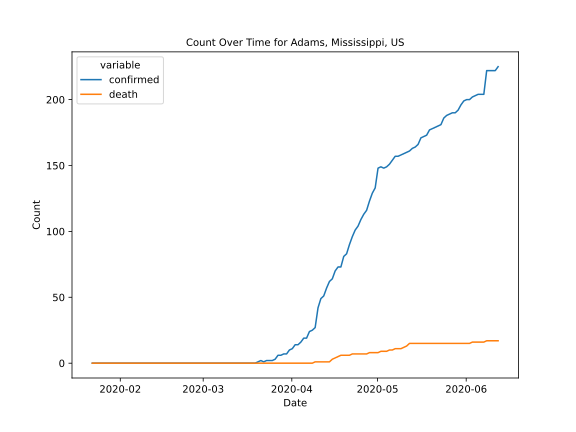

In [10]:
%%fsql
data = LOAD "/tmp/covid19.parquet"
SELECT * WHERE key = 'Adams, Mississippi, US'
TRANSFORM PREPARTITION BY key PRESORT  date USING plotter(key_col="key")
OUTPUT USING render_all

Noticed the partitioning statement that was used. `PREPARTITION BY` takes in a column to be used in creating the partitions. The partition can be on the city or state. These partitioned DataFrames are then independently passed to the `plotter` function, and the output is then collected after. Partitioning by state will run `plotter` once for each state.

The next thing to note is the `PRESORT`. Seaborn automatically sorts the x-value of the plot, but to be sure that the values are in chronological order, we can apply a `PRESORT` as the data is being partitioned so that it is already ordered by the time the `transformer` is applied. 

## Visualize with Spark

We only want to draw charts for the top 3 states with highest death numbers. In the following code, we will first find the top 3 states, then use `SEMI JOIN` to filter the dataset, and use the transformer to plot. 

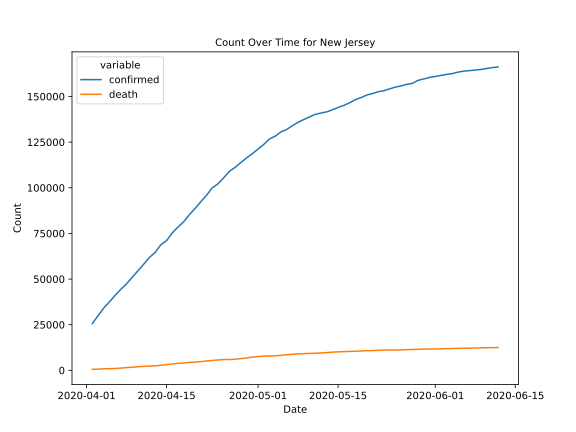

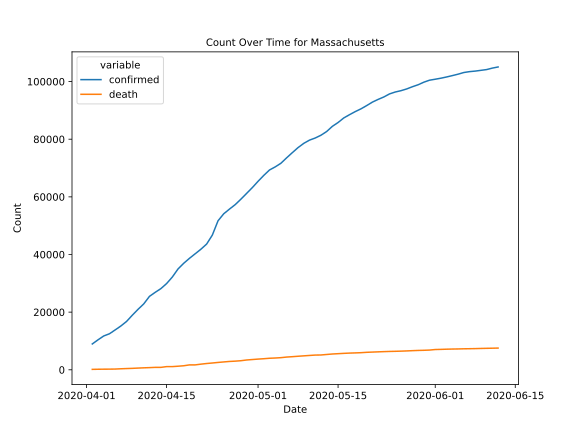

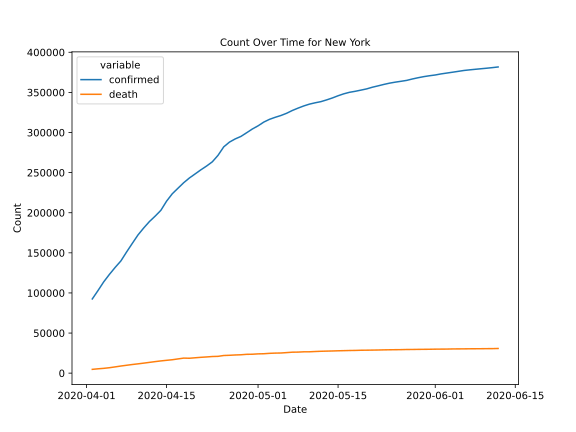

In [11]:
%%fsql spark
data = LOAD "/tmp/covid19.parquet"

top3 = 
    SELECT state, SUM(death) AS death 
    FROM data GROUP BY state 
    ORDER BY death DESC LIMIT 3 PERSIST

data = 
    SELECT * 
    FROM data 
    LEFT SEMI JOIN top3 
    ON data.state = top3.state
    WHERE date > '2020-04-01'

agg = SELECT state, date, SUM(confirmed) AS confirmed, SUM(death) AS death
      FROM data
      GROUP BY state, date

-- this will use the last dataframe by default
TRANSFORM PREPARTITION BY state USING plotter(key_col="state")
OUTPUT USING render_all


## Productionizing

In order to bring this to production, all we have to do is pass the SQL code into the `fsql` function. To run this on Spark, pass the `SparkExecutionEngine` to the run method.

In [12]:
from fugue_sql import fsql
query = """
data = LOAD "/tmp/covid19.parquet"

top3 = 
    SELECT state, SUM(death) AS death 
    FROM data GROUP BY state 
    ORDER BY death DESC LIMIT 3 PERSIST
    PRINT
"""

fsql(query).run(SparkExecutionEngine)

,state,death
0,New York,1690428
1,New Jersey,558989
2,Massachusetts,301008


DataFrames()

## Summary

In this example we have shown how FugueSQL can be used as the primary language for data analysis workflows. We were able to write our code by focusing on the partition level. When we were ready to apply it to a bigger dataset, all we had to do was specify the `SparkExecutionEngine`. Fugue allows users to specify the execution engine by changing one line of code.

FugueSQL is compatible with ANSI SQL, but it has enhancements that make it capable of describing computation workflows. Here we showed the variable assignment and additional keywords like `PERSIST`, `PREPARTITION` and `TRANSFORM` that allow FugueSQL to utilize Python functions and the Spark engine. 